In [5]:
import pyprind
import os
import sys
import time
import datetime
import re
import json
import csv
import pickle

dest = os.path.join('authorship', 'pkl_objects')
if not os.path.exists(dest):
    os.makedirs(dest)
    print(dest)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.dataframe as dd

from tweepy import API
from tweepy import OAuthHandler
from tweepy import Cursor
from tweepy import TweepError

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException 
from selenium.common.exceptions import StaleElementReferenceException

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix

# Mining Tweets

## Helpter Functions

### Twitter Authetication

In [6]:
def get_twitter_auth():
    """Setup Twitter Authentication.
    
    Return: tweepy.OAuthHandler object
    """
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    return auth
    
def get_twitter_client():
    """Setup Twitter API Client.
    
    Return: tweepy.API object
    """
    auth = get_twitter_auth()
    client = API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)
    return client

### File Management

In [7]:
def makedir(screen_name):
    """Create subdirectory 'users/screen_name' to store mined data.
    
    Params
    -------
    screen_name : str
    """
    dirname = 'users/{}'.format(screen_name)

    try:
        os.makedirs(dirname, mode=0o755, exist_ok=True)
    except OSError:
        print('Directory {} already exists.'.format(dirname))
    except Exception as e:
        print('Error while creating directory {}'.format(dirname))
        print(e)
        sys.exit(1)

def get_user_tweets(screen_name, no_rt=True):
    """Get tweets for a given user (3,200 limit)
    
    Create a subdir named 'users'.
    In this subdir, a jsonl file will store all the tweets writen
    by the given user.
    
    Params
    -------
    screen_name : str    
    """
    # Make dir structure
    makedir(screen_name)

    total_tweets = 0
    fname = 'users/{0}/usr_timeline_{0}.jsonl'.format(screen_name)
    with open(fname, 'a') as f:
        for page in Cursor(client.user_timeline, screen_name=screen_name, count=200).pages(16): 
            for tweet in page:
                total_tweets += 1
                if no_rt:
                    if not tweet.retweeted and 'RT @' not in tweet.text:
                        f.write(json.dumps(tweet._json)+'\n')
                else:
                    f.write(json.dumps(tweet._json)+'\n')
    return total_tweets

In [8]:
def twitter_url(screen_name, no_rt, start, end):
    """Form url to access tweets via Twitter's search page.
    Params
    -------
    screen_name : str
    no_rt : bool
    start : datetime-onj
    end : datetime-obj
    
    Return: string
    """
    url1 = 'https://twitter.com/search?f=tweets&q=from%3A'
    url2 = screen_name + '%20since%3A' + start.strftime('%Y-%m-%d') 
    url3 = ''
    if no_rt:
        url3 = '%20until%3A' + end.strftime('%Y-%m-%d') + '%20&src=typd'
    else:
        url3 = '%20until%3A' + end.strftime('%Y-%m-%d') + '%20include%3Aretweets&src=typd'
    
    return url1 + url2 + url3
    
def increment_day(date, i):
    """Increment day object by i days.
    
    Params
    -------
    date : datetime-obj
    i : int
    
    Return: datetime object
    """
    return date + datetime.timedelta(days=i)

### Get Tweets for Given User

In [9]:
def get_all_user_tweets(screen_name, start, end, no_rt=True):
    """
    Params
    ------
    screen_name : str
    start : datetime-obj
    end : datetime-obj
    no_rt : bool
    
    """
    # Special parameters
    fname_tweet_ids = 'users/{0}/usr_tweetids_{0}.jsonl'.format(screen_name)
    
    # Make dir structure
    makedir(screen_name)
    
    # Selenium parames
    delay = 1  # time to wait on each page load before reading the page
    driver = webdriver.Chrome() 
    tweet_selector = 'li.js-stream-item'
    id_selector = '.time a.tweet-timestamp'
    
    ids_total = 0
    for day in range((end - start).days + 1):
        # Get Twitter search url
        startDate = increment_day(start, 0)
        endDate = increment_day(start, 1)
        url = twitter_url(screen_name, no_rt, startDate, endDate)

        driver.get(url)
        time.sleep(delay)
        
        try:
            found_tweets = driver.find_elements_by_css_selector(tweet_selector)
            increment = 10

            # Scroll through the Twitter search page
            while len(found_tweets) >= increment:
                print('scrolling down to load more tweets')
                driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
                time.sleep(delay)
                found_tweets = driver.find_elements_by_css_selector(tweet_selector)
                increment += 10

            # Get the IDs for all Tweets
            ids = []
            with open(fname_tweet_ids, 'a') as fout:
                for tweet in found_tweets:
                    try:
                        tweet_id = tweet.find_element_by_css_selector(
                                    id_selector).get_attribute('href').split('/')[-1]
                        ids.append(tweet_id)
                        ids_total += 1
                    except StaleElementReferenceException as e:
                        print('lost element reference', tweet)
                        
                # Save ids to file
                data_to_write = list(set(ids))
                fout.write(json.dumps(data_to_write)+'\n')
            print('{} tweets found, {} total'.format(len(found_tweets), ids_total))
        
        except NoSuchElementException:
            print('no tweets on this day')

        start = increment_day(start, 1)
    
    # Close selenium driver
    driver.close()
    
    return ids_total

## Obatining the Data

In [10]:
from config import *
client = get_twitter_client()

### Mine Tweets

In [82]:
screen_names = ['AP', 'FoxNews', 'nytimes']
small_batch = True
start = datetime.datetime(2017, 1, 10)  
end = datetime.datetime(2017, 1, 16)    
fname_tweet_ids = 'all_ids.json'
total_tweets = []

if small_batch:
    for screen_name in screen_names:
        num_tweets = get_user_tweets(screen_name)
        total_tweets.append(num_tweets)
else: 
    for screen_name in screen_names:
        num_tweets = get_all_user_tweets(screen_name, start, end, no_rt=True)
        total_tweets.append(num_tweets)

In [83]:
print(total_tweets)

[3200, 3200, 3200]


### Clean Data

In [90]:
f_authorship = 'users/authorship.csv'

pbar = pyprind.ProgBar(sum(total_tweets))
with open(f_authorship, 'w') as fout:
    writer = csv.writer(fout)
    # Header
    writer.writerow(['text','id','user_id'])

    for screen_name in screen_names:
        if small_batch:
            fin = 'users/{0}/usr_timeline_{0}.jsonl'.format(screen_name)
            with open(fin, 'r') as f:
                for line in f:
                    tweet = json.loads(line)
                    writer.writerow([tweet['text'], tweet['id'], tweet['user']['id']])
                    #fout.write('"{0}",{1},{2}\n'.format(tweet['text'].encode("utf-8"), tweet['id'], tweet['user']['id']))
                    pbar.update()
        else:
            fin = 'users/{0}/usr_tweetids_{0}.jsonl'.format(screen_name)
            with open(fin, 'r') as f:
                for line in f:
                    ids = json.loads(line)
                    
                    for tweetId in ids:
                        tweet = client.get_status(tweetId)
                        writer.writerow([tweet.text, tweet.id, tweet.user.id])
                        #fout.write('"{0}",{1},{2}\n'.format(tweet.text.encode("utf-8"), tweet.id, tweet.user.id))
                        pbar.update()

0%                          100%
[#######################       ] | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00 | ETA: 00:00:00

# Preprocessing

## Input Data

In [14]:
f_authorship = 'users/authorship.csv'
df = dd.read_csv(f_authorship)
df.tail(3)

,text,id,user_id
7619,"In the '80s and '90s, gangs of Australian teen...",826309321793368064,807095
7620,Dana Boente: Who Is the New Acting Attorney Ge...,826304418488451073,807095
7621,"Frugal Traveler: A $1,000 Day in Sydney for $1...",826302097066962944,807095


In [15]:
print(len(df))
df.drop_duplicates()
print(len(df))

7622
7622


In [16]:
f_authorship = 'users/authorship.csv'
df = pd.read_csv(f_authorship)
print(df.shape)
df.drop_duplicates()
print(df.shape)
df.head(3)

(7622, 3)
(7622, 3)


,text,id,user_id
0,"Today on #APLatino: Brazil's Carnival, Dems pi...",835732714124890112,51241574
1,Duped into killing Kim? Two suspects say it lo...,835722972866424833,51241574
2,"#APExplains Rio's Carnival, a high-stakes samb...",835717713079255040,51241574


## Cleaning Data -> Prprocessing and Tokenization

In [17]:
stop = stopwords.words('english')

def preprocessor(text):
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text) + ' '.join(emoticons).replace('-', '')
    return text

def tokenizer(text):
    return text.split()

porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tweet_token = TweetTokenizer()
def tokenizer_twitter(text):
    return tweet_token.tokenize(text)

In [18]:
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
#df['text'] = df['text'].apply(preprocessor)

X = df.loc[:, 'text'].values
y = df.loc[:, 'user_id'].values
le = LabelEncoder()
y = le.fit_transform(y)
print(np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

[0 1 2]


# Learning

In [21]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, tokenizer_twitter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, tokenizer_twitter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

gs_lr_tfidf = GridSearchCV(lr_tfidf, 
                           param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [22]:
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 12.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 1)], 'vect__stop_words': [['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', '...se_idf': [False], 'vect__norm': [None], 'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 10.0, 100.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
    

In [98]:
print('Best parameter set: {} \n'.format(gs_lr_tfidf.best_params_))
print('CV Accuracy: {:.3f}'.format(gs_lr_tfidf.best_score_))

Best parameter set: {'clf__C': 100.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_twitter at 0x7f89b99b5b70>, 'vect__use_idf': False} 

CV Accuracy: 0.872


In [99]:
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: {:.3f}'.format(clf.score(X_test, y_test)))

Test Accuracy: 0.874


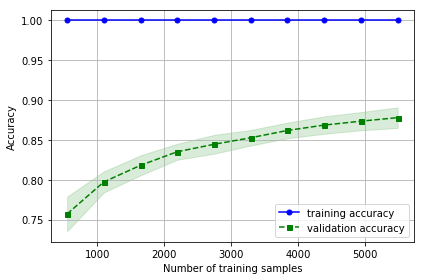

In [101]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=clf,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=-1)
    
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

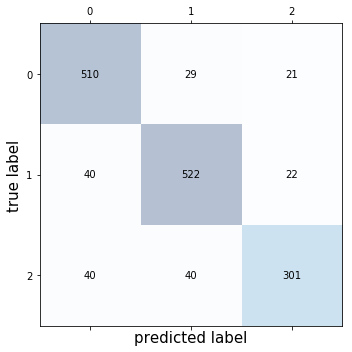

In [105]:
y_pred = clf.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('predicted label', fontsize=15)
plt.ylabel('true label', fontsize=15)

plt.tight_layout()
# plt.savefig('./figures/confusion_matrix.png', dpi=300)
plt.show()

In [106]:
from sklearn.svm import SVC

pipe_svc = Pipeline([('vect', tfidf),
                     ('clf', SVC(random_state=1))])

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, tokenizer_twitter],
               'clf__C': param_range, 
               'clf__kernel': ['linear']},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, tokenizer_twitter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__C': param_range, 
               'clf__kernel': ['linear']},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, tokenizer_twitter],
               'clf__C': param_range, 
               'clf__gamma': param_range, 
               'clf__kernel': ['rbf']},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, tokenizer_twitter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__C': param_range, 
               'clf__gamma': param_range, 
               'clf__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=5,
                  verbose=1,
                  n_jobs=-1)

In [107]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 46.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 440.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 497.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 559.6min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 634.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 729.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 833.4min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed: 867.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...bf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 1)], 'vect__stop_words': [['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', '...000.0], 'clf__gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'clf__kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
    

In [119]:
print('Best parameter set: {} \n'.format(gs.best_params_))
print('CV Accuracy: {:.3f}'.format(gs.best_score_))
clf_svc = gs.best_estimator_
print('Test Accuracy: {:.3f}'.format(clf_svc.score(X_test, y_test)))

Best parameter set: {'clf__C': 10.0, 'clf__gamma': 0.01, 'clf__kernel': 'rbf', 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_twitter at 0x7f89b99b5b70>, 'vect__use_idf': False} 

CV Accuracy: 0.894
Test Accuracy: 0.900


In [111]:
from sklearn.naive_bayes import MultinomialNB

nb_pipe = Pipeline([('vect', tfidf),
                    ('clf', MultinomialNB())])

param_range = [0.25, 0.5, 0.75, 1.0]
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, tokenizer_twitter],
               'clf__alpha': param_range},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, tokenizer_twitter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__alpha': param_range}]
                   
nb = GridSearchCV(estimator=nb_pipe, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=5,
                  verbose=1,
                  n_jobs=-1)

In [112]:
nb.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...rue,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 1)], 'vect__stop_words': [['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', '...89b99b5b70>], 'vect__use_idf': [False], 'vect__norm': [None], 'clf__alpha': [0.25, 0.5, 0.75, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
    

In [120]:
print('Best parameter set: {} \n'.format(nb.best_params_))
print('CV Accuracy: {:.3f}'.format(nb.best_score_))
clf_nb = nb.best_estimator_
print('Test Accuracy: {:.3f}'.format(clf_nb.score(X_test, y_test)))

Best parameter set: {'clf__alpha': 0.5, 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_twitter at 0x7f89b99b5b70>, 'vect__use_idf': False} 

CV Accuracy: 0.823
Test Accuracy: 0.824


In [117]:
from sklearn.linear_model import SGDClassifier

sgd_pipe = Pipeline([('vect', tfidf),
                     ('clf', SGDClassifier(random_state=42)),])

param_range = [0.25, 0.5, 0.75, 1.0]
param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, tokenizer_twitter],
               'clf__loss' : ['hinge', 'log'],
               'clf__penalty' : ['l1', 'l2'],
               'clf__n_iter' : [3,5,7],
               'clf__alpha': param_range},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter, tokenizer_twitter],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__loss' : ['hinge', 'log'],
               'clf__penalty' : ['l1', 'l2'],
               'clf__n_iter' : [3,5,7],
               'clf__alpha': param_range}]

sgd = GridSearchCV(estimator=sgd_pipe, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=5,
                  verbose=1,
                  n_jobs=-1)

In [118]:
sgd.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 47.0min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...     penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 1)], 'vect__stop_words': [['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', '...og'], 'clf__penalty': ['l1', 'l2'], 'clf__n_iter': [3, 5, 7], 'clf__alpha': [0.25, 0.5, 0.75, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
    

In [121]:
print('Best parameter set: {} \n'.format(sgd.best_params_))
print('CV Accuracy: {:.3f}'.format(sgd.best_score_))
clf_sgd = sgd.best_estimator_
print('Test Accuracy: {:.3f}'.format(clf_sgd.score(X_test, y_test)))

Best parameter set: {'clf__alpha': 0.25, 'clf__loss': 'hinge', 'clf__n_iter': 3, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_twitter at 0x7f89b99b5b70>, 'vect__use_idf': False} 

CV Accuracy: 0.669
Test Accuracy: 0.656


In [2]:
pickle.dump(clf, open(os.path.join(dest, 'logit.pkl'), 'wb'), protocol=4)
pickle.dump(clf_svc, open(os.path.join(dest, 'svc.pkl'), 'wb'), protocol=4)
pickle.dump(clf_nb, open(os.path.join(dest, 'nb.pkl'), 'wb'), protocol=4)
pickle.dump(clf_sgd, open(os.path.join(dest, 'sgd.pkl'), 'wb'), protocol=4)

NameError: name 'clf' is not defined

In [19]:
clf1 = pickle.load(open(os.path.join(dest, 'logit.pkl'), 'rb'))
clf2 = pickle.load(open(os.path.join(dest, 'svc.pkl'), 'rb'))
clf3 = pickle.load(open(os.path.join(dest, 'nb.pkl'), 'rb'))
clf4 = pickle.load(open(os.path.join(dest, 'sgd.pkl'), 'rb'))

In [20]:
print('Best parameter set: {} \n'.format(clf1.best_params_))
print('CV Accuracy: {:.3f}'.format(clf1.best_score_))
print('Test Accuracy: {:.3f}'.format(clf1.score(X_test, y_test)))

AttributeError: 'Pipeline' object has no attribute 'best_params_'

In [23]:
pickle.dump(gs_lr_tfidf, open(os.path.join(dest, 'trial.pkl'), 'wb'), protocol=4)
clf0 = pickle.load(open(os.path.join(dest, 'trial.pkl'), 'rb'))

In [24]:
print('Best parameter set: {} \n'.format(clf0.best_params_))
print('CV Accuracy: {:.3f}'.format(clf0.best_score_))
print('Test Accuracy: {:.3f}'.format(gs_lr_tfidf.best_estimator_.score(X_test, y_test)))

Best parameter set: {'clf__C': 100.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_twitter at 0x7f9261ff9158>, 'vect__use_idf': False} 

CV Accuracy: 0.872
Test Accuracy: 0.874
